In [95]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline 
from sklearn.model_selection import KFold 
from sklearn.preprocessing import OneHotEncoder
import random
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
import math
import xgboost as xgb
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.tree import _tree
from xgboost.sklearn import XGBRegressor
#from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_val_score


In [96]:
train_df = pd.read_csv("train.csv", header=0)
test_df = pd.read_csv("test.csv", header = 0)
# convert datetime column in training data into multiple columns (year/month/day/hour/weekday)
dt = pd.to_datetime(train_df["datetime"]) # convert string to datetime type
train_df["year"] = dt.map(lambda x: x.year) 
train_df["month"] = dt.map(lambda x: x.month)
train_df["day"] = dt.map(lambda x: x.day)
train_df["hour"] = dt.map(lambda x: x.hour)
train_df["weekday"] = dt.map(lambda x: x.weekday())


In [97]:
encode_feature = train_df[['season','holiday','workingday','weather']].values
enc = OneHotEncoder()
encode_result = enc.fit_transform(encode_feature).toarray()
features = train_df.drop(['season','holiday','workingday','weather'], axis=1) 
features = features.drop(["datetime", "temp", "casual", "registered","count"], axis=1) 
encoded_features = np.concatenate([encode_result,features.values], axis = 1)
after_encode.shape

(10886, 20)

### Train test split

In [98]:
train_df['log_count'] = train_df['count'].apply(np.log1p)

In [99]:
x_train, x_test, y_train, y_test = train_test_split (encoded_features, train_df['count'], test_size = 0.3, random_state = 99)

In [100]:
x_log_train, x_log_test, y_log_train, y_log_test = train_test_split (encoded_features, train_df['log_count'] , test_size = 0.3, random_state = 99)

## Functions

In [101]:
# Evaluation
def cal_rmsle(pred, actual):
    rmlse = np.sqrt(np.mean((np.log(np.array(pred) + 1)- np.log(np.array(actual) + 1))**2))
    return rmlse
# test example
cal_rmsle([1,2,3],[2,6,2])

0.56717915832655263

In [125]:
def parameterTunning(Model, parameters, X_train, y_train):

    clf = GridSearchCV(Model, parameters, cv=5, scoring='r2')
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")   
    print(clf.best_estimator_)
    print("Grid scores on development set:")

    #grid_scores_ returns:
    # a dict of parameter settings
    # the mean score over the cross-validation folds 
    # the list of scores for each fold
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))

## Decision Tree

In [103]:
model_dt = tree.DecisionTreeRegressor()
model_dt.fit(x_train, y_train)
pred_dt = model_dt.predict(x_test)
rmsle_dt = cal_rmsle(y_test, pred_dt)
print("Decision tree RMSLE(default):",rmsle_dt) 

Decision tree RMSLE(default): 0.415521257739


In [104]:
parameters = [
    {'max_depth':[9,10,11,20,25,50]},
    {'min_samples_leaf':[1,2,5,10,50,100]},
    {'min_samples_split':[2,5,10,50,100]},
    {'presort':[True, False]},
    {'min_weight_fraction_leaf':[0.0, 0.1, 0.3, 0.4, 0.5]}]   
 
parameterTunning(tree.DecisionTreeRegressor(), parameters, x_train, y_train)

Best parameters set found on development set:
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
Grid scores on development set:
0.864 (+/-0.013) for {'max_depth': 9}
0.885 (+/-0.008) for {'max_depth': 10}
0.895 (+/-0.006) for {'max_depth': 11}
0.891 (+/-0.011) for {'max_depth': 20}
0.890 (+/-0.010) for {'max_depth': 25}
0.894 (+/-0.008) for {'max_depth': 50}
0.890 (+/-0.009) for {'min_samples_leaf': 1}
0.901 (+/-0.005) for {'min_samples_leaf': 2}
0.907 (+/-0.007) for {'min_samples_leaf': 5}
0.892 (+/-0.006) for {'min_samples_leaf': 10}
0.806 (+/-0.018) for {'min_samples_leaf': 50}
0.732 (+/-0.014) for {'min_samples_leaf': 100}
0.889 (+/-0.009) for {'min_samples_split': 2}
0.897 (+/-0.008) for {'min_samples_split': 5}
0.906 (+/-0.007) for {'min_samples_s

In [106]:
# Best set
model_dt = tree.DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, presort=False, random_state=66,
           splitter='best')
model_dt.fit(x_train, y_train)
pred_dt = model_dt.predict(x_test)
rmsle_dt = cal_rmsle(y_test, pred_dt)
print("Decision tree RMSLE(default):",rmsle_dt) 

Decision tree RMSLE(default): 0.379658948838


## Random Forest

In [107]:
model_rf = RandomForestRegressor()
model_rf.fit(x_train, y_train)
pred_rf = model_rf.predict(x_test)
rmsle_rf = cal_rmsle(y_test, pred_rf)
print("Random forest RMSLE(default):",rmsle_rf) 

Random forest RMSLE(default): 0.333104192715


In [ ]:
# test log
model_rf = RandomForestRegressor()
model_rf.fit(x_log_train, y_log_train)
pred_rf = np.expm1(model_rf.predict(x_log_test))
rmsle_rf = cal_rmsle(y_log_test, pred_rf)
print("Random forest RMSLE(log):",rmsle_rf) 

In [108]:
parameters = [
    {'max_depth':[50,100, 500]}, 
    {'n_estimators':[10, 50, 100, 200, 500]}, 
    {'min_samples_leaf':[1,2,5,10,50,100]}, #2
    {'min_samples_split':[2,5,10,50,100]}, #10
    {'min_weight_fraction_leaf':[0.0, 0.1, 0.3, 0.4, 0.5]}] #0.0    
    
#Parameter tunning
parameterTunning(RandomForestRegressor(), parameters,x_train, y_train)

Best parameters set found on development set:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Grid scores on development set:
0.937 (+/-0.004) for {'max_depth': 50}
0.938 (+/-0.003) for {'max_depth': 100}
0.938 (+/-0.003) for {'max_depth': 500}
0.936 (+/-0.003) for {'n_estimators': 10}
0.944 (+/-0.003) for {'n_estimators': 50}
0.945 (+/-0.003) for {'n_estimators': 100}
0.946 (+/-0.003) for {'n_estimators': 200}
0.946 (+/-0.003) for {'n_estimators': 500}
0.937 (+/-0.004) for {'min_samples_leaf': 1}
0.939 (+/-0.002) for {'min_samples_leaf': 2}
0.931 (+/-0.005) for {'min_samples_leaf': 5}
0.917 (+/-0.003) for {'min_samples_leaf': 10}
0.799 (+/-0.007) for {'min_samples_leaf': 50}
0.724

In [112]:
# Best set   
model_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=66,
           verbose=0, warm_start=False)
model_rf.fit(x_train, y_train)
pred_rf = model_rf.predict(x_test)
rmsle_rf = cal_rmsle(y_test, pred_rf)
print("Random forest RMSLE(best):",rmsle_rf) 

Random forest RMSLE(best): 0.315217792801


In [86]:
model_rf = RandomForestRegressor()
model_rf.fit(x_log_train, y_log_train)
pred_rf = np.expm1(model_rf.predict(x_log_test))
rmsle_rf = cal_rmsle(y_log_test, pred_rf)
print("Random forest RMSLE(log):",rmsle_rf) 

Random forest RMSLE(default): 3.12212364773


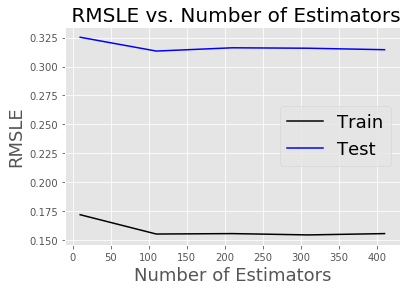

In [114]:
rmsle_train=[]
rmsle_test=[]
for k in range(10, 501, 100):
    clf = ensemble.RandomForestRegressor(
        n_estimators=k)
 
    clf.fit(x_train, y_train)
    result = clf.predict(x_train)
    rmsle_train.append(
        cal_rmsle(y_train, result))
    
    clf.fit(x_train, y_train)
    result = clf.predict(x_test)
    rmsle_test.append(
        cal_rmsle(y_test,result))
  
#Plot the data
x=range(10, 501,100)
plt.style.use('ggplot')
plt.plot(x, rmsle_train, 'k')
plt.plot(x, rmsle_test, 'b')
plt.xlabel('Number of Estimators', fontsize=18)
plt.ylabel('RMSLE', fontsize=18)
plt.legend(['Train', 'Test'], fontsize=18)
plt.title(' RMSLE vs. Number of Estimators', fontsize=20)

In [115]:
model_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=66,
           verbose=0, warm_start=False)
model_rf.fit(x_train, y_train)
pred_rf = model_rf.predict(x_test)
rmsle_rf = cal_rmsle(y_test, pred_rf)
print("Random forest RMSLE:",rmsle_rf) 

Random forest RMSLE(best): 0.315968474497


###  ExtraTreesRegressor

In [123]:
from sklearn.ensemble import ExtraTreesRegressor
# test
model_et = ExtraTreesRegressor(n_estimators=10,random_state=66)
model_et.fit(x_train, y_train)
pred_et = model_et.predict(x_test)
rmsle_et = cal_rmsle(y_test, pred_et)
print("ExtraTreesRegressor RMSLE(default):",rmsle_et)

ExtraTreesRegressor RMSLE(default): 0.335498918863


In [127]:
parameters = [
    {'n_estimators':[10, 50, 100, 200, 500]}, 
    {'min_samples_leaf':[1,2,5,10,50,100]}, #2
    {'min_samples_split':[2,5,10,50,100]}, #10
    {'min_weight_fraction_leaf':[0.0, 0.1, 0.3, 0.4, 0.5]}]   
    
#Parameter tunning
parameterTunning(ExtraTreesRegressor(), parameters,x_train, y_train)

Best parameters set found on development set:
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
Grid scores on development set:
0.939 (+/-0.003) for {'n_estimators': 10}
0.947 (+/-0.003) for {'n_estimators': 50}
0.947 (+/-0.003) for {'n_estimators': 100}
0.948 (+/-0.003) for {'n_estimators': 200}
0.948 (+/-0.003) for {'n_estimators': 500}
0.939 (+/-0.004) for {'min_samples_leaf': 1}
0.940 (+/-0.004) for {'min_samples_leaf': 2}
0.931 (+/-0.003) for {'min_samples_leaf': 5}
0.915 (+/-0.003) for {'min_samples_leaf': 10}
0.822 (+/-0.007) for {'min_samples_leaf': 50}
0.715 (+/-0.009) for {'min_samples_leaf': 100}
0.938 (+/-0.004) for {'min_samples_split': 2}
0.940 (+/-0.003) for {'min_samples_sp

In [130]:
model_et = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
model_et.fit(x_train, y_train)
pred_et = model_et.predict(x_test)
rmsle_et = cal_rmsle(y_test, pred_et)
print("ExtraTreesRegressor RMSLE:",rmsle_et) 

ExtraTreesRegressor RMSLE: 0.307013586447
